# Ignore warnings

In [46]:
import warnings
warnings.simplefilter("ignore")

# Liberaries

In [47]:
# Data analysis liberaries:
import pandas as pd
import numpy as np

# Visualisation Liberaries:
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#modeling
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
import time
from scipy.stats import randint

#metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error

# Import data

In [48]:
data = pd.read_csv("T1.csv")

In [49]:
data.shape

(50530, 5)

# Split data to train set and test set

In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

# Some explorations

In [51]:
train.shape

(35371, 5)

In [52]:
train.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
7419,26 02 2018 00:20,0.000000,9.198621,2272.739614,76.988640
31338,11 08 2018 21:00,3593.535889,13.950780,3600.000000,51.584980
24569,25 06 2018 14:40,2135.379883,9.519311,2455.115289,49.725101
33552,27 08 2018 12:00,524.973877,5.963931,612.891442,25.624689
50319,30 12 2018 12:50,0.000000,0.474268,0.000000,254.585007


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35371 entries, 7419 to 15795
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      35371 non-null  object 
 1   LV ActivePower (kW)            35371 non-null  float64
 2   Wind Speed (m/s)               35371 non-null  float64
 3   Theoretical_Power_Curve (KWh)  35371 non-null  float64
 4   Wind Direction (°)             35371 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.6+ MB


<div class="alert alert-block alert-info">
<b>Note:</b> `Date/Time` column has a wrong data type
</div>

In [54]:
train['Date/Time'] = pd.to_datetime(train['Date/Time'],format='%d %m %Y %H:%M')

# Extract  month, and hour into separate columns
train['Month'] = train['Date/Time'].dt.month
train['Hour'] = train['Date/Time'].dt.hour

In [55]:
train.drop(['Date/Time'],axis=1,inplace=True)

In [56]:
train.isna().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Month                            0
Hour                             0
dtype: int64

<div class="alert alert-block alert-info">
<b>Note:</b> There is no missing values
</div>

In [57]:
train.duplicated().sum()

0

In [58]:
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


<div class="alert alert-block alert-info">
<b>Note:</b> There are active power values less than 0. These values are wrong.
    
</div>

In [59]:
train = train[train['LV ActivePower (kW)'] >= 0]

# EDA

In [60]:
#define function to show histogram and boxplot for each column in the dataset
def plot_hist_and_boxplot(data , columns):
    # Create subplots based on the number of columns
    fig , axes = plt.subplots(nrows = len(columns), ncols = 2 , figsize = (12,4*len(columns)))
    # Flatten the axes for easier indexing
    axes = axes.flatten()
    # Loop through each column and plot histogram and boxplot
    for i, column in enumerate(columns):
        # histplot
        sns.histplot(data[column],kde = True,ax = axes[i*2])
        #set title
        axes[i*2].set_title(f'{column} - KDE Plot')

        # Boxplot
        sns.boxplot(x=data[column],ax=axes[i*2+1])
        #set title
        axes[i*2+1].set_title(f'{column} - Boxplot')

    # Adjust layout
    plt.tight_layout()
    #show the plot
    plt.show()

In [61]:
def plot_numerical_vs_LV_ActivePower(data, columns):
    num_columns = len(columns)
    num_rows = (num_columns + 1) // 2  # Calculate the number of rows needed

    # Create subplots based on the number of columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))
    # Flatten the axes for easier indexing
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        sns.scatterplot(data=data, y='LV ActivePower (kW)', x=column, ax=axes[i])
        axes[i].set_title(f'{column} vs LV ActivePower')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('LV ActivePower (kW)')
        axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(num_columns, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


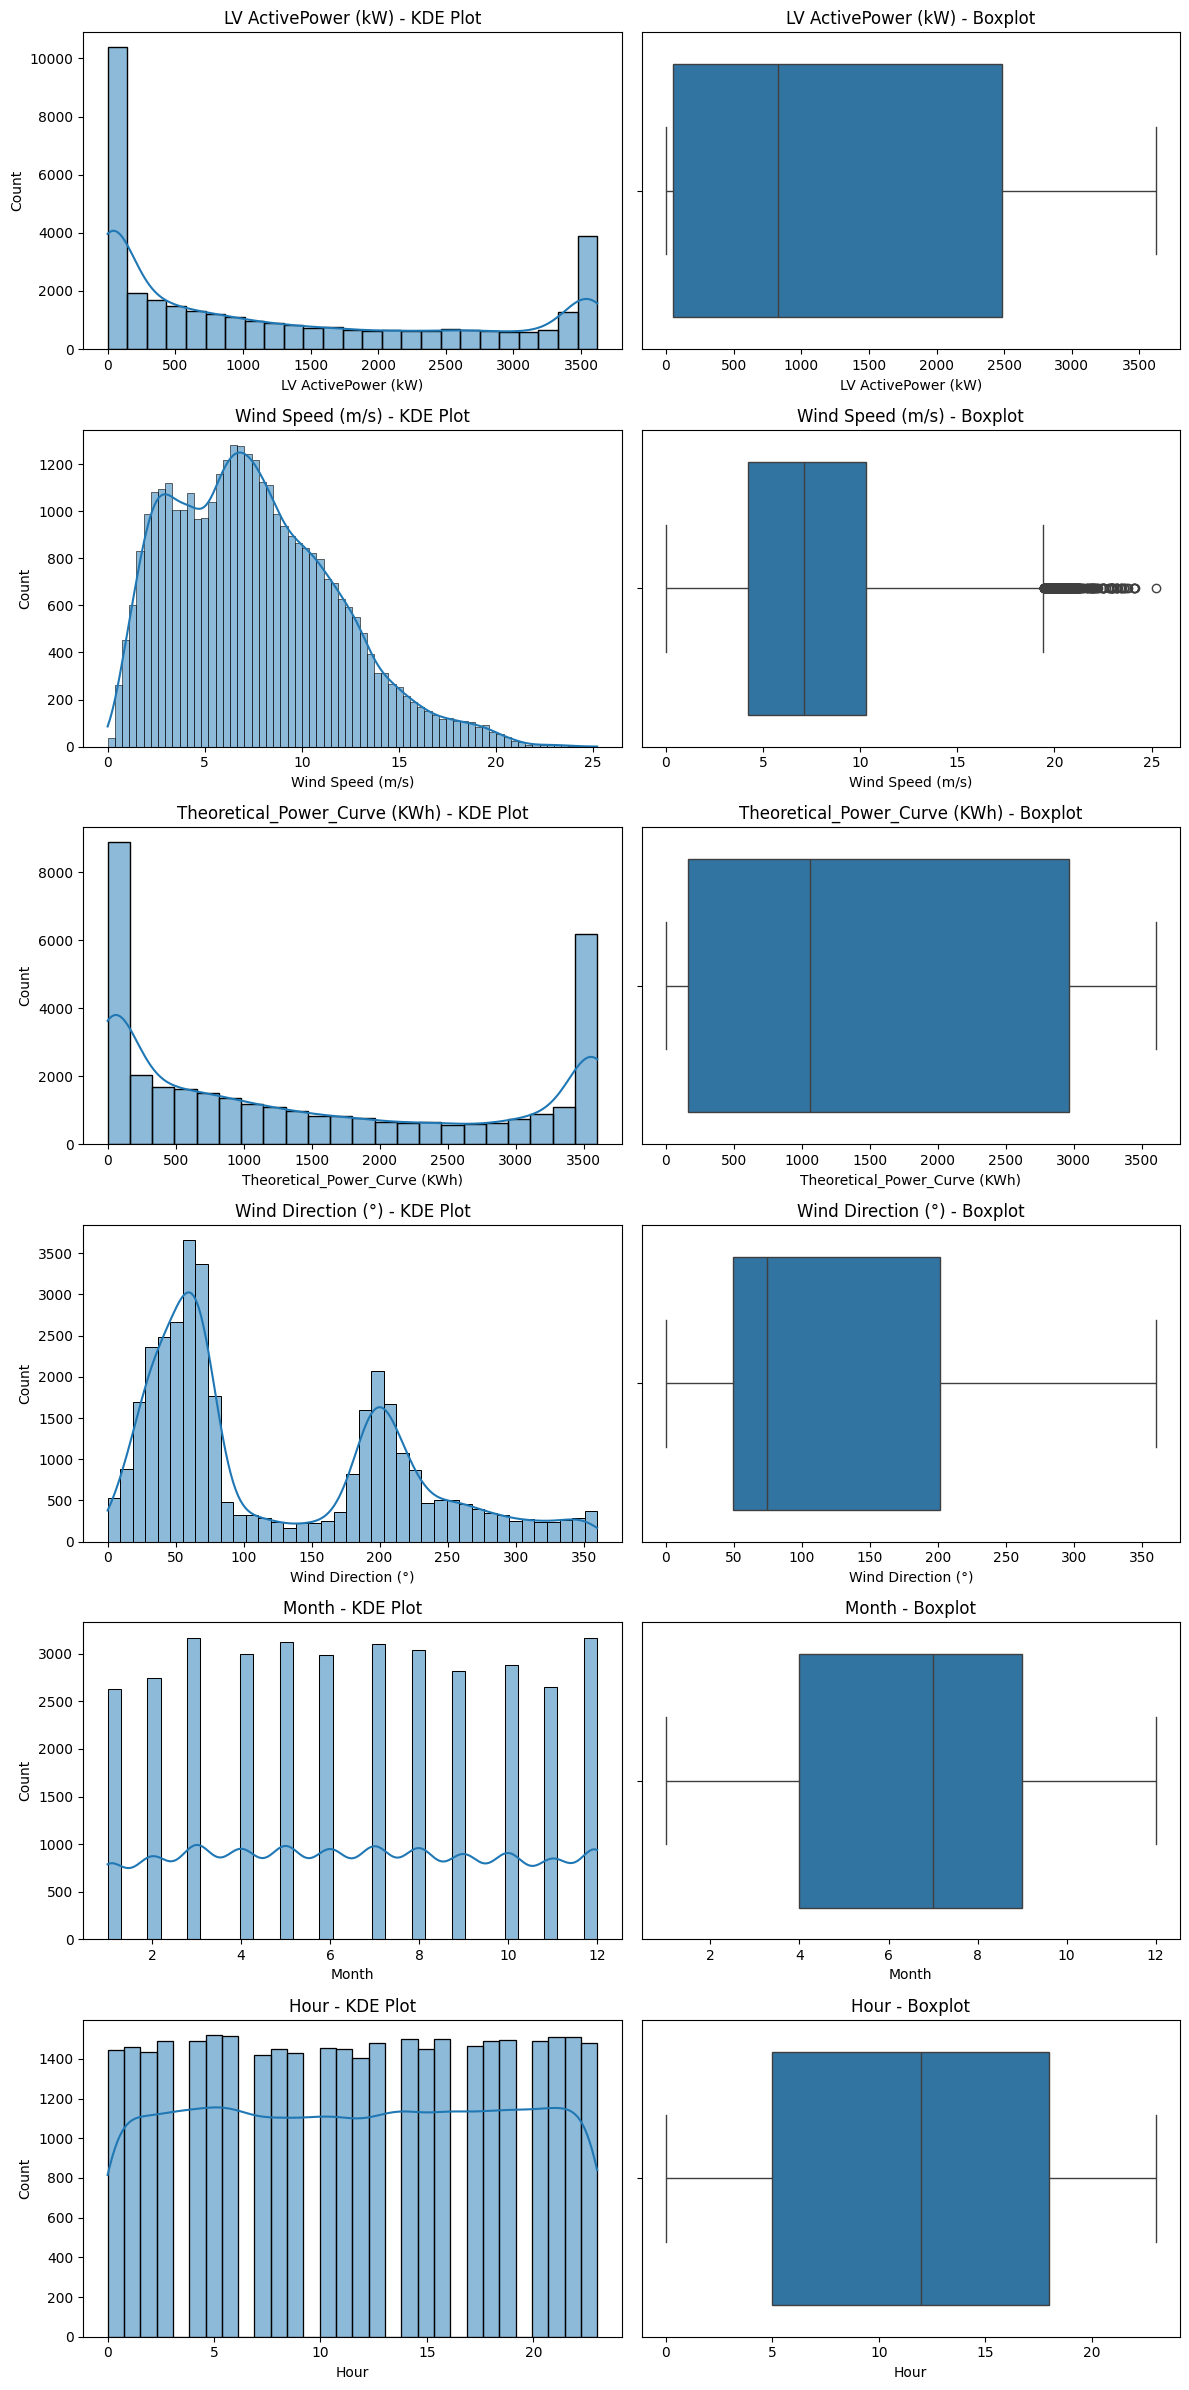

In [62]:
numeric_columns = train.select_dtypes(include=['number']).columns.tolist()
plot_hist_and_boxplot(train, numeric_columns)

<div class="alert alert-block alert-info">
<b>Observations:</b> 
    
<b> 1-There are some outliers in wind speed column
    
<b> 2-There is skewness in our features
    
</div>

## Dealing with outliers

In [63]:
q1 = train["Wind Speed (m/s)"].quantile(0.25)
q3 = train["Wind Speed (m/s)"].quantile(0.75)

IQR = q3 - q1

outliers = train[(train["Wind Speed (m/s)"] < q1-1.5*IQR) | (train["Wind Speed (m/s)"] > q3+1.5*IQR)]
outliers_percentage = round(len(outliers)/len(train)*100, 2)
print(f"{outliers_percentage}% of our data are outliers")

0.84% of our data are outliers


<div class="alert alert-block alert-info">
<b>Dicision:</b> I will drop outliers as they represent a small proportion of the data
</div>

In [64]:
train = train[~((train["Wind Speed (m/s)"] < q1-1.5*IQR) | (train["Wind Speed (m/s)"] > q3+1.5*IQR))]

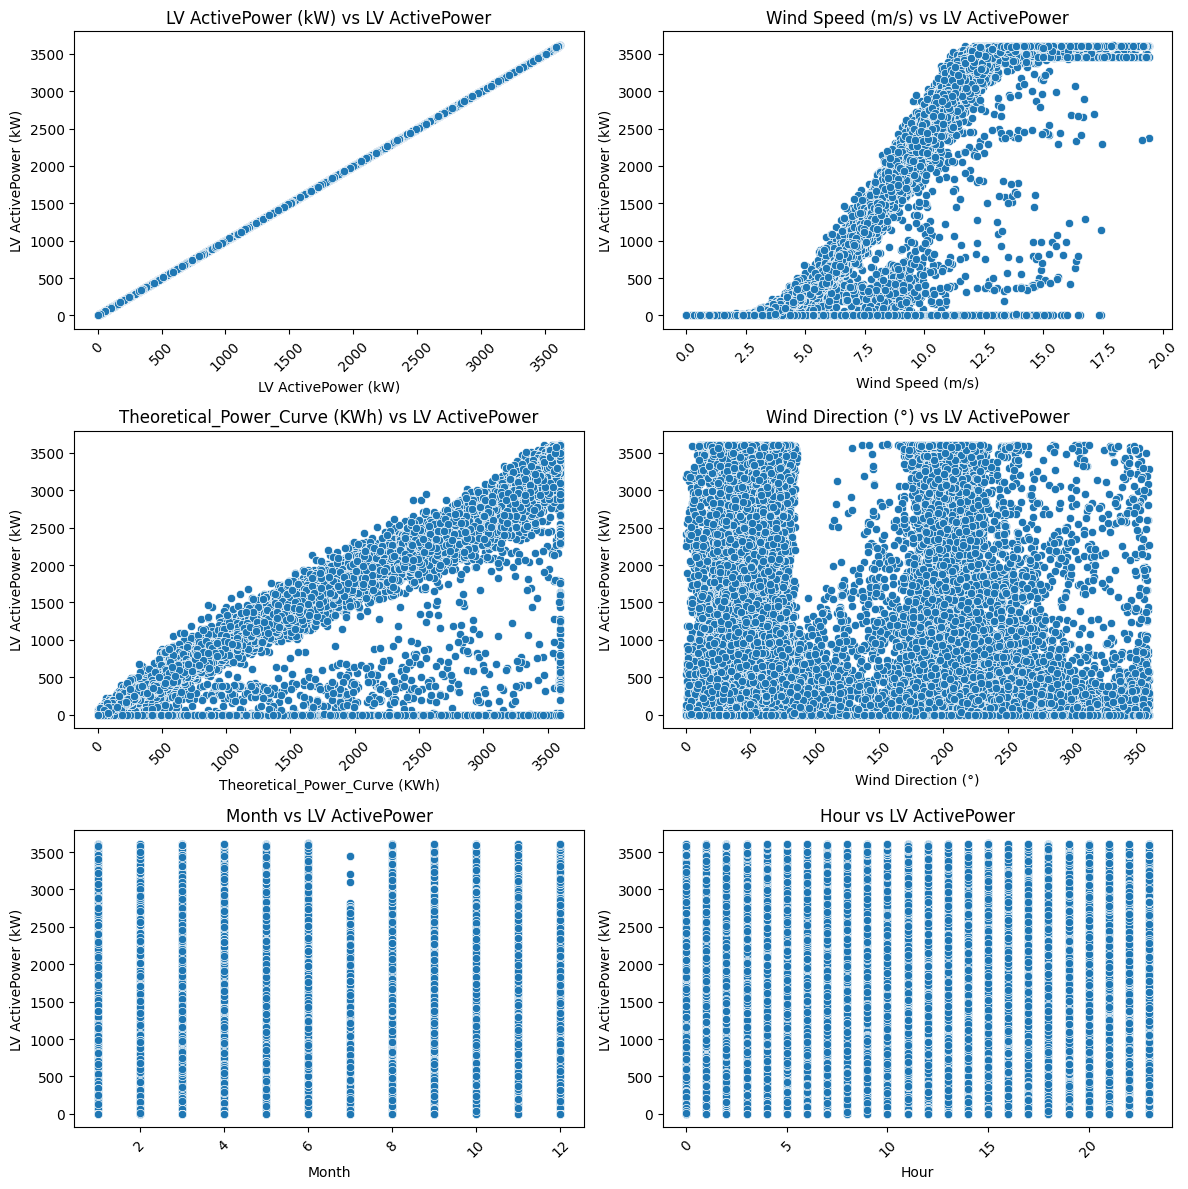

In [65]:
plot_numerical_vs_LV_ActivePower(train,numeric_columns)

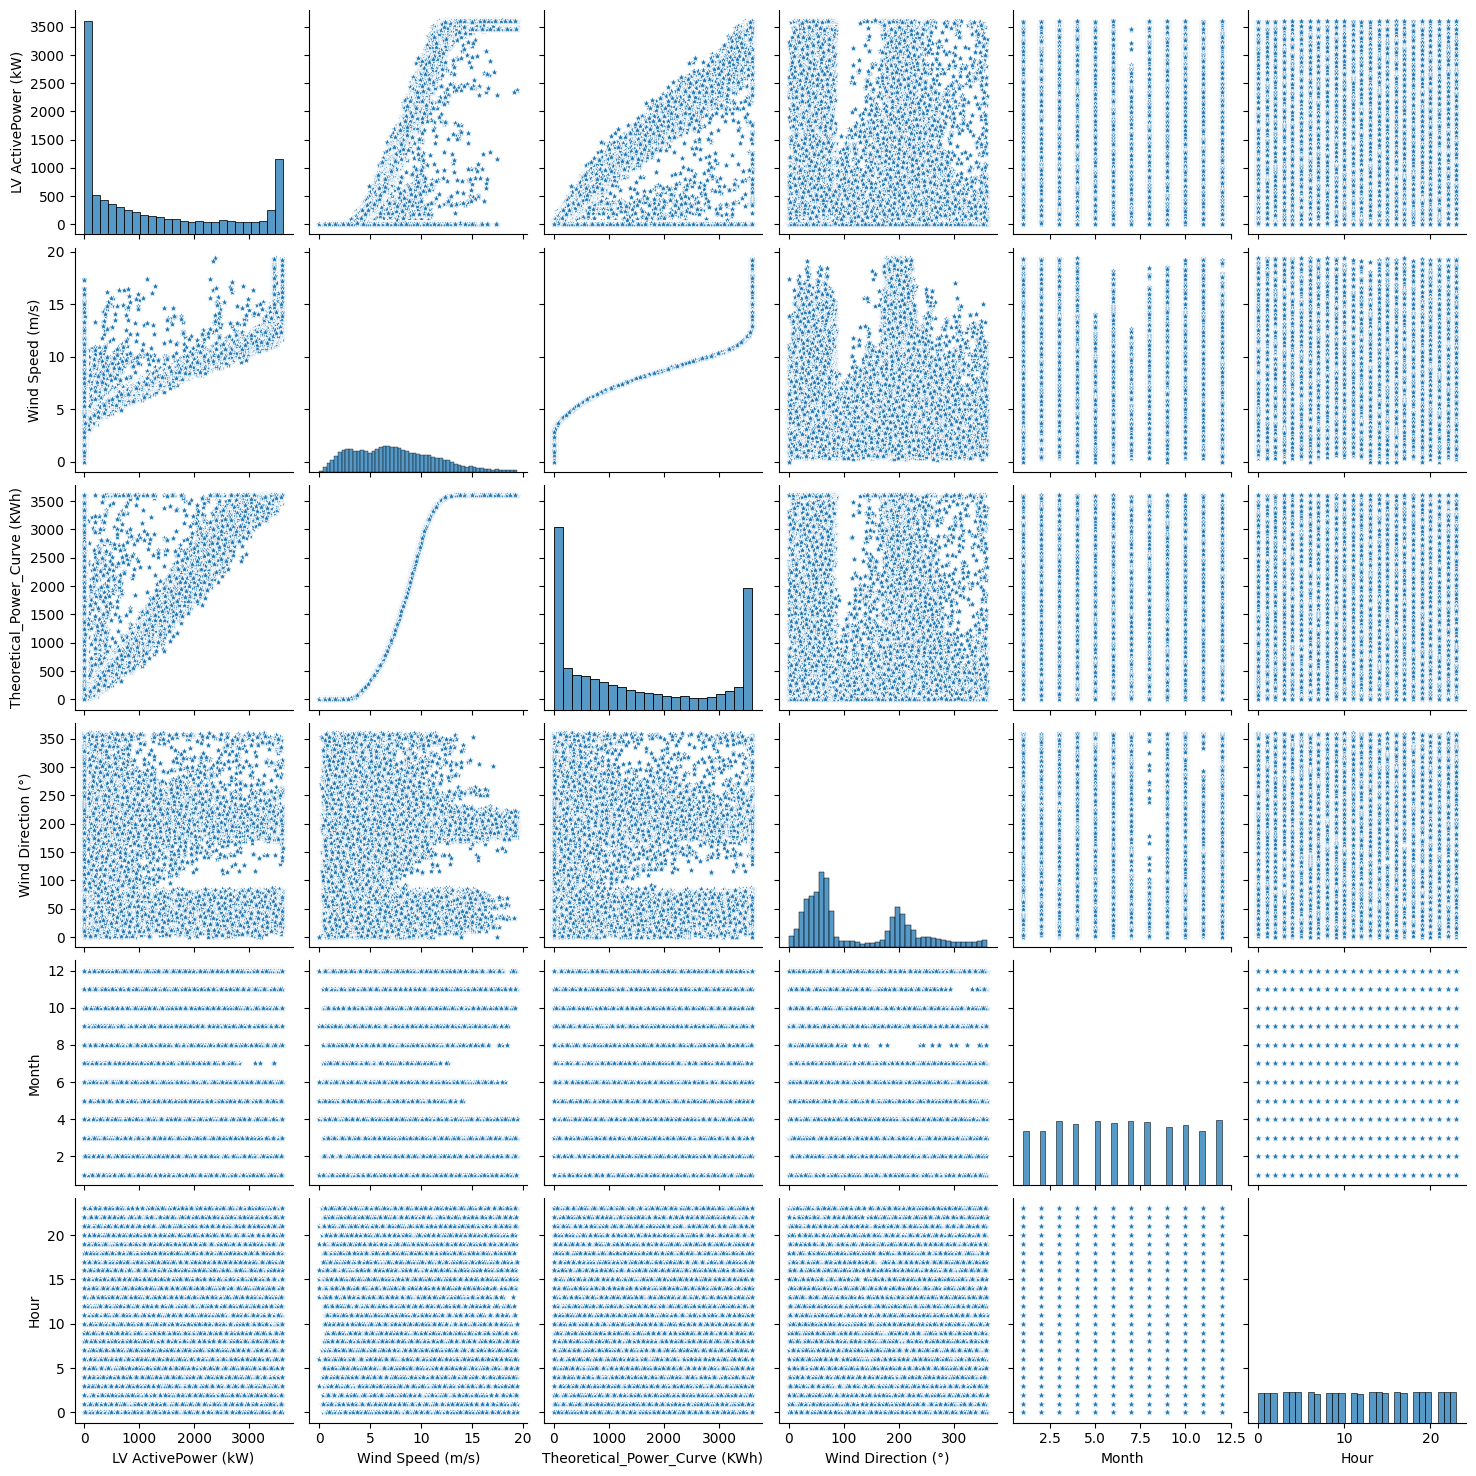

In [66]:
sns.pairplot(train, markers='*')

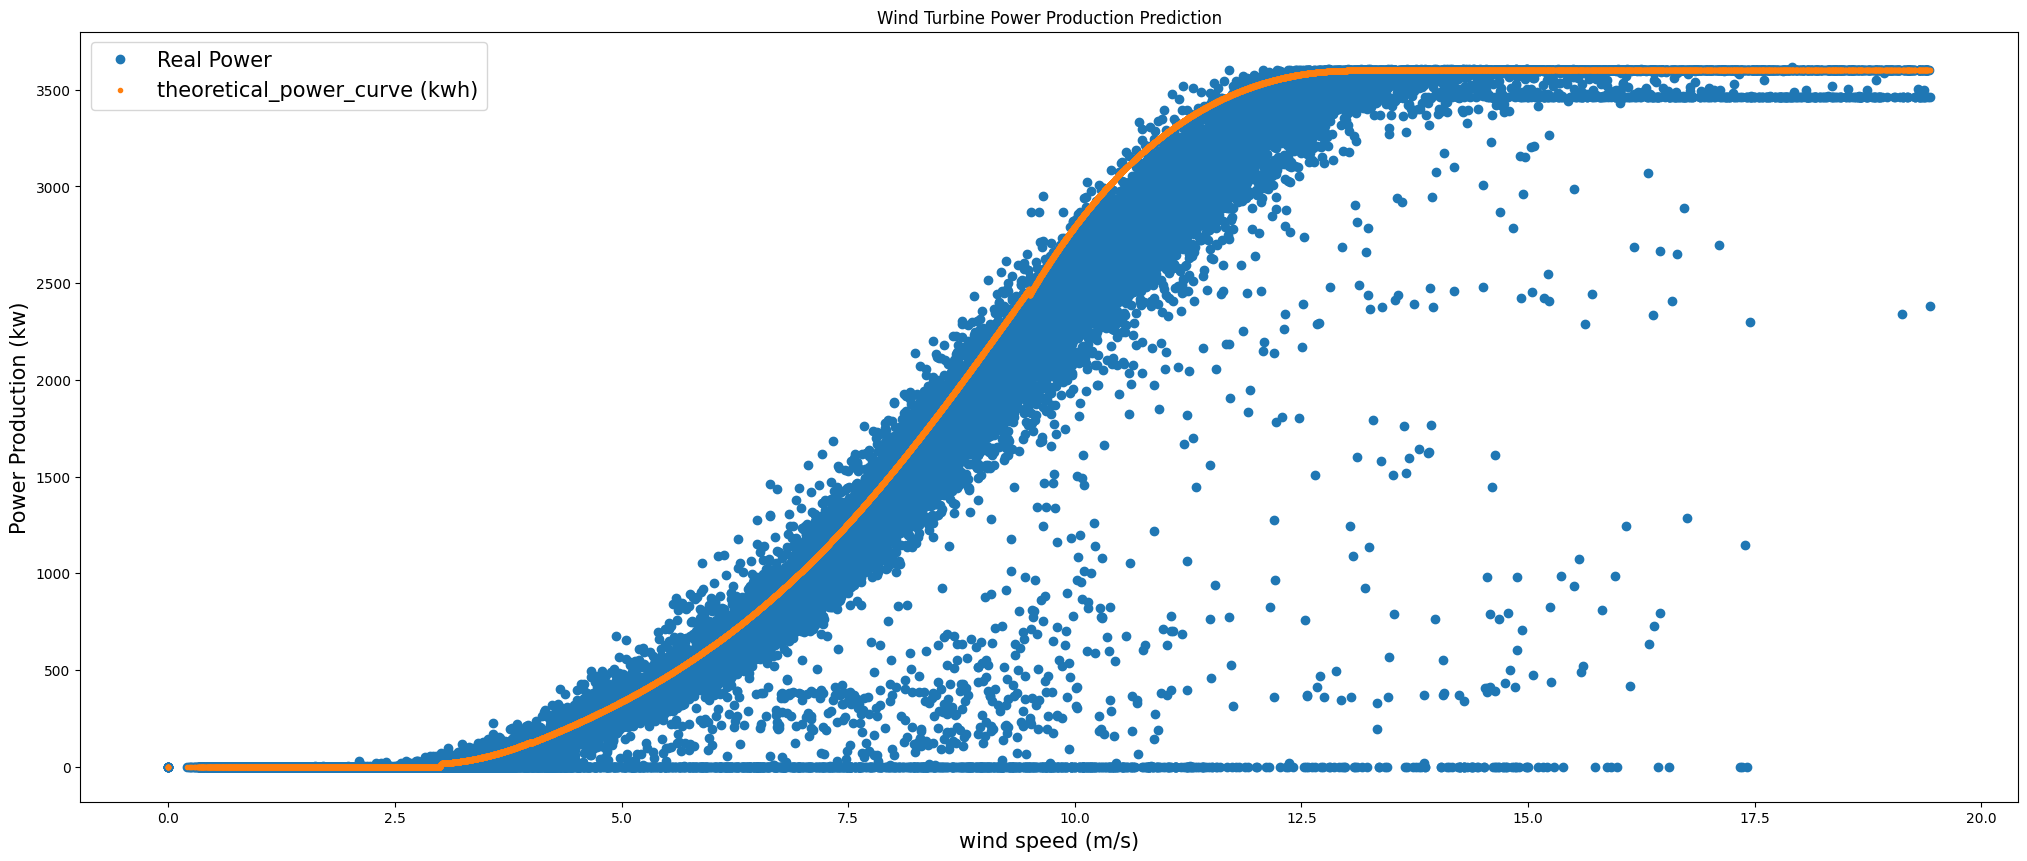

In [67]:

exp = train['LV ActivePower (kW)']
the = train['Theoretical_Power_Curve (KWh)']
plt.figure(figsize=(25,10)) 
plt.plot(train['Wind Speed (m/s)'], train['LV ActivePower (kW)'], 'o', label='Real Power')
plt.plot(train['Wind Speed (m/s)'], train['Theoretical_Power_Curve (KWh)'], '.', label='theoretical_power_curve (kwh)')
plt.xlabel('wind speed (m/s)', size=15)
plt.ylabel('Power Production (kw)', size=15)
plt.title('Wind Turbine Power Production Prediction')
plt.legend(fontsize=15)
plt.show()

<div class="alert alert-block alert-info">
<b>Observations:</b> There are some instances that has 0 active power although they have high wind speed values
</div>

In [68]:
train = train[~((train['LV ActivePower (kW)'] == 0) & (train['Wind Speed (m/s)'] > 5))]

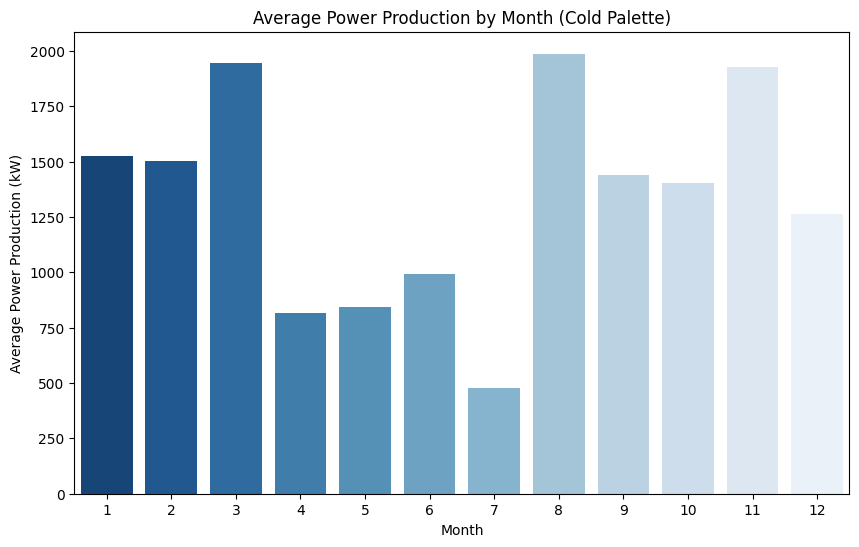

In [69]:
# Group by month and calculate the mean power production
monthly = train.groupby('Month').mean('LV ActivePower (kW)').sort_values('LV ActivePower (kW)').reset_index()

# Plot the average power production by month with a cold palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='LV ActivePower (kW)', data=monthly , palette='Blues_r')
plt.title('Average Power Production by Month (Cold Palette)')
plt.xlabel('Month')
plt.ylabel('Average Power Production (kW)')
plt.show()

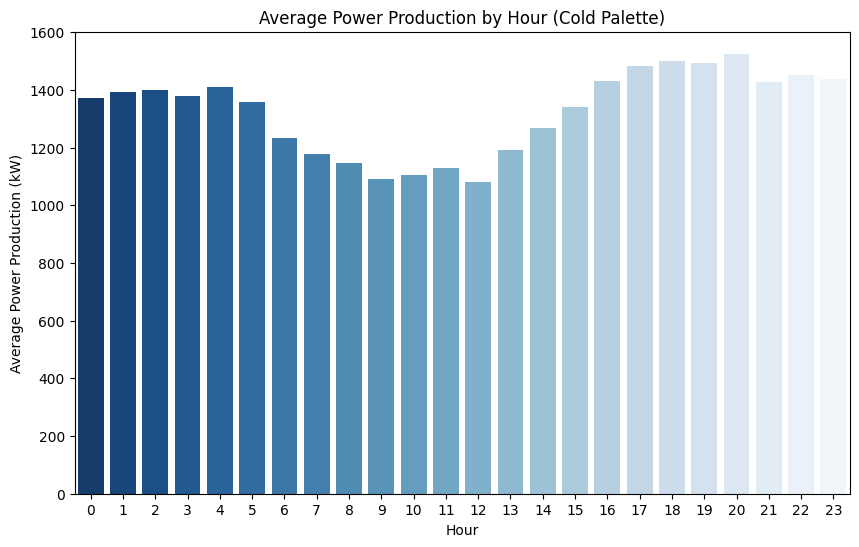

In [70]:
# Group by hour and calculate the mean power production
hourly = train.groupby('Hour').mean('LV ActivePower (kW)').sort_values('LV ActivePower (kW)').reset_index()

# Plot the average power production by hour with a cold palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Hour', y='LV ActivePower (kW)', data=hourly , palette='Blues_r')
plt.title('Average Power Production by Hour (Cold Palette)')
plt.xlabel('Hour')
plt.ylabel('Average Power Production (kW)')
plt.show()

<Axes: >

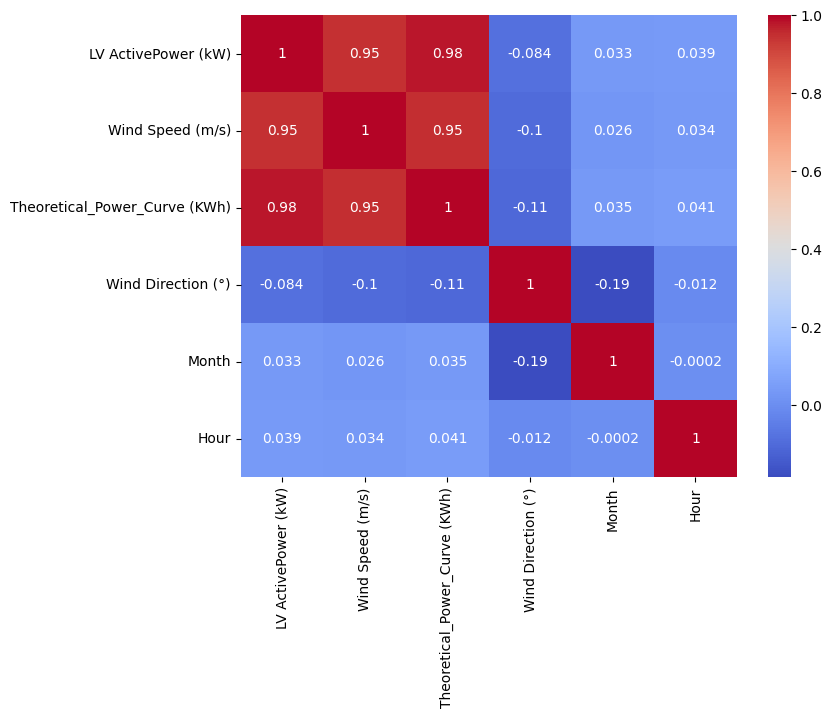

In [71]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(train.corr(), cmap = 'coolwarm', annot = True, ax=ax)

# Preprocessing

## Handling skewness

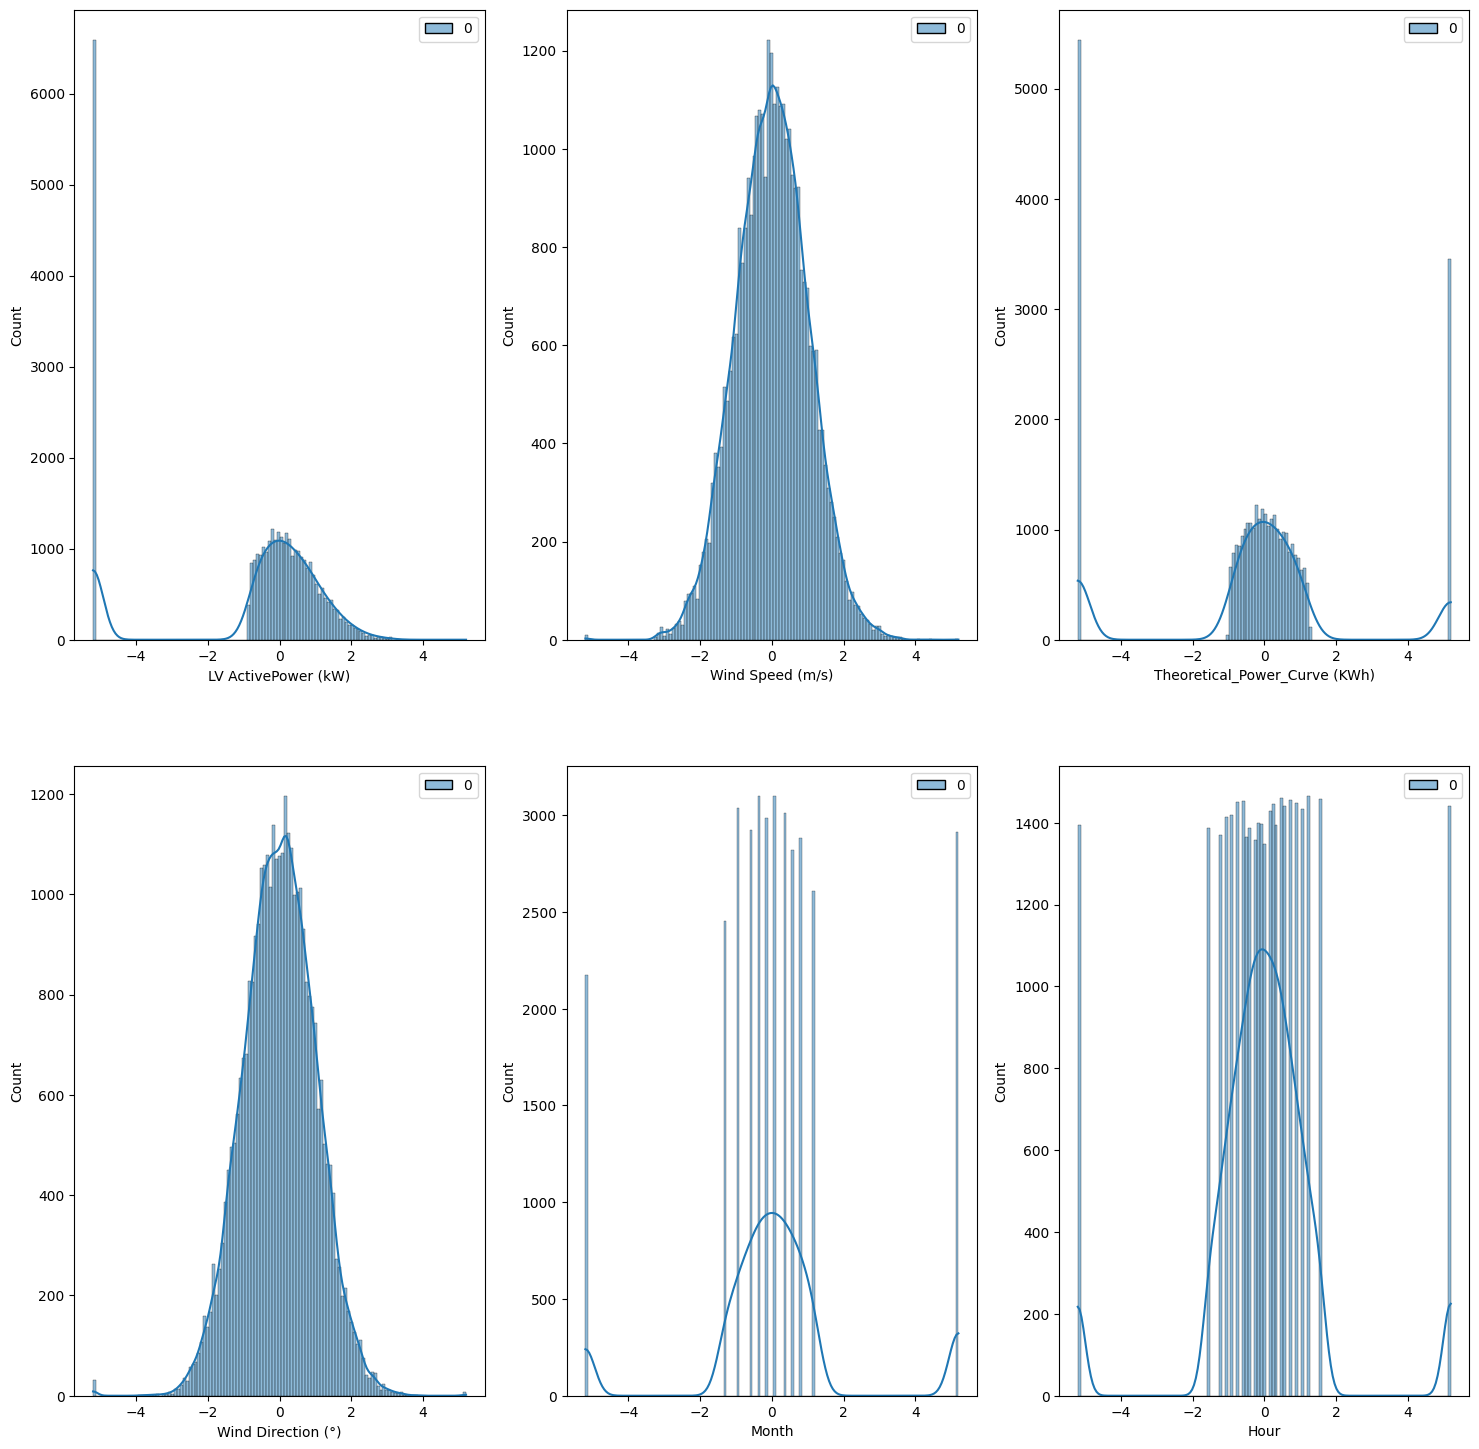

In [72]:
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, QuantileTransformer

Quantile_Transformer = []
fig = plt.figure(figsize=(18,18))
c = 1
for col in train.columns:
    QuantileTr = QuantileTransformer(output_distribution='normal')
    df_quantile = pd.DataFrame(QuantileTr.fit_transform(train[col].values.reshape(-1,1)))
    plt.subplot(2,3,c)
    g = sns.histplot(df_quantile, kde=True)
    g.set(xlabel = col)
    c = c + 1
    Quantile_Transformer.append(round(df_quantile.skew()[0],2))
    
plt.show()

## clean test

In [73]:
def clean_test(data):
    # Handling 'Date/Time' column
    data['Date/Time'] = pd.to_datetime(data['Date/Time'],format='%d %m %Y %H:%M')
    data['Month'] = data['Date/Time'].dt.month
    data['Hour'] = data['Date/Time'].dt.hour
    data.drop(['Date/Time'],axis=1,inplace=True)
    
    # Remove wrong values in 'LV ActivePower (kW)' column
    data = data[data['LV ActivePower (kW)'] >= 0]
    data = data[~((data['LV ActivePower (kW)'] == 0) & (data['Wind Speed (m/s)'] > 5))]
    
    return data

In [74]:
test = clean_test(test)

# Split train and test datasets:

In [75]:
x_train = train.drop("LV ActivePower (kW)", axis=1)
y_train = train["LV ActivePower (kW)"]

x_test = test.drop("LV ActivePower (kW)", axis=1)
y_test = test["LV ActivePower (kW)"]

# Feature Importance

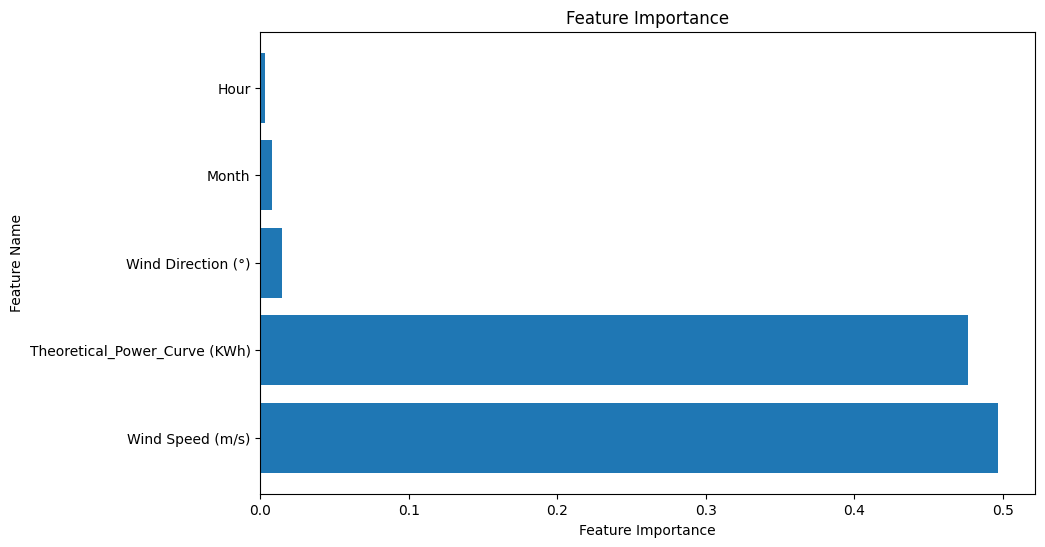

In [76]:
model = RandomForestRegressor(random_state=42)

model.fit(x_train, y_train)

feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({"Feature":x_train.columns, "Importance":feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()

In [77]:
def get_hours_by_power_range(hourly_data):
    global low_power_hours, medium_power_hours, high_power_hours
    
    # Define the classes based on the mean 'LV ActivePower (kW)' values
    classes = {
        'Low': (hourly_data['LV ActivePower (kW)'] < 1200),
        'Medium': (hourly_data['LV ActivePower (kW)'] >= 1200) & (hourly_data['LV ActivePower (kW)'] < 1400),
        'High': (hourly_data['LV ActivePower (kW)'] >= 1400)
    }

    # Get hours corresponding to each power range
    low_power_hours = hourly_data[classes['Low']]['Hour'].tolist()
    medium_power_hours = hourly_data[classes['Medium']]['Hour'].tolist()
    high_power_hours = hourly_data[classes['High']]['Hour'].tolist()

    return low_power_hours, medium_power_hours, high_power_hours

In [78]:
low_power_hours, medium_power_hours, high_power_hours = get_hours_by_power_range(hourly)

# Now you can use low_power_hours, medium_power_hours, and high_power_hours globally
print("Low power hours:", low_power_hours)
print("Medium power hours:", medium_power_hours)
print("High power hours:", high_power_hours)

Low power hours: [12, 9, 10, 11, 8, 7, 13]
Medium power hours: [6, 14, 15, 5, 0, 3, 1, 2]
High power hours: [4, 21, 16, 23, 22, 17, 19, 18, 20]


In [79]:
get_hours_by_power_range(hourly)

([12, 9, 10, 11, 8, 7, 13],
 [6, 14, 15, 5, 0, 3, 1, 2],
 [4, 21, 16, 23, 22, 17, 19, 18, 20])

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin

class NumberReplacer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        replacements = {
            tuple(low_power_hours): 1,
            tuple(medium_power_hours): 2,
            tuple(high_power_hours): 3
        }
        
        X_copy = X.copy()
        for nums, value in replacements.items():
            X_copy.replace(nums, value, inplace=True)
        
        return X_copy.values.reshape(-1, 1)

In [81]:
class WindSpeedRangeReplacer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            # Convert Series to DataFrame with a single column
            X = pd.DataFrame(X, columns=['Wind Speed (m/s)'])
        
        # Check if the column 'Wind Speed (m/s)' exists in the DataFrame
        if 'Wind Speed (m/s)' not in X.columns:
            raise KeyError("Column 'Wind Speed (m/s)' not found in the DataFrame")
        
        # Replace continuous 'Wind Speed (m/s)' values with specified ranges
        X_copy = X.copy()
        X_copy['Wind Speed Range'] = pd.cut(X_copy['Wind Speed (m/s)'], 
                                            bins=[-np.inf, 5, 10, 15, 20, 25],
                                            labels=['0-5', '6-10', '11-15', '16-20', '21-25'],
                                            right=False)
        # Drop the original 'Wind Speed (m/s)' column
        X_copy.drop(columns=['Wind Speed (m/s)'], inplace=True)
        return X_copy.values.reshape(-1, 1)

## Pipeline:

In [82]:
# Select categorical columns
cat_cols = x_train.select_dtypes(include=['object']).columns
# Select numerical columns
num_cols = list(x_train.select_dtypes(include=['int64', 'float64']).columns)
num_cols.remove('Hour')
# Initialize the RobustScaler for numerical columns
scaler = RobustScaler()
# Initialize the OrdinalEncoder for categorical columns
encoder = OrdinalEncoder()
# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', encoder)
        ]), cat_cols),
        ('num', Pipeline(steps=[
            ('scaler', scaler),
            ('quantile', QuantileTransformer(output_distribution='normal'))
        ]), num_cols),
        ('hour', Pipeline(steps=[
            ('replce', NumberReplacer())
        ]), 'Hour'),
    ])
preprocessor

ValueError: list.remove(x): x not in list

In [ ]:
# Apply ColumnTransformer to x_train and x_test
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

NameError: name 'preprocessor' is not defined

# splitting train to train and validation

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                      test_size = 0.2, random_state = 42)

# Modeling

In [ ]:
model_name= []
mae = []
R2 = []
training_time = []

models = [
    LinearRegression(),
    SGDRegressor(random_state=42),
    Ridge(alpha=0.1, solver="cholesky",fit_intercept=False),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    Lasso(alpha=0.1),
    DecisionTreeRegressor(),
    RandomForestRegressor(random_state=42),
    HistGradientBoostingRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    XGBRegressor(learning_rate = 0.1, max_depth = 8, n_estimators = 200),
    LGBMRegressor(random_state=42)
]

for model in models :
    
    start_time = time.time()
    model.fit(x_train , y_train)
    fitting_time = time.time() - start_time
    
    prediction = model.predict(x_valid)
    model_name.append(model.__class__.__name__)
    mae.append(round(mean_absolute_error(y_valid, prediction), 4))
    R2.append(str(r2_score(y_valid, prediction)))
    training_time.append(fitting_time)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.

You can set `force_row_wise=true` to remove the overhead.

And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Total Bins 781

[LightGBM] [Info] Number of data points in the train set: 27209, number of used features: 5

[LightGBM] [Info] Start training from score 1326.907709


In [ ]:
models_df = pd.DataFrame({"model-name":model_name, "MAE": mae,"R2":R2, 'training-time':training_time })
models_df = models_df.set_index('model-name')
models_df.sort_values("MAE")

,MAE,R2,training-time
model-name,,,
XGBRegressor,69.8600,0.9820001751943692,1.406541
LGBMRegressor,70.9513,0.9832499009340283,0.099609
HistGradientBoostingRegressor,72.1926,0.982006804510763,0.416210
RandomForestRegressor,75.0649,0.9789833120947448,10.767084
ExtraTreesRegressor,79.1458,0.9768569497326488,4.065754
DecisionTreeRegressor,97.6455,0.9617745170307671,0.182191
SGDRegressor,383.9650,0.8399843596660994,0.081554
LinearRegression,391.3971,0.841542561635412,0.006843
Lasso,391.4817,0.8415413650831794,0.000000


<div class="alert alert-block alert-info">
<b>XGBRegressor	is the best model</b>
</div>

# Evaluate model on test

In [ ]:
best_model = XGBRegressor(learning_rate = 0.1, max_depth = 8, n_estimators = 200)

final_model = best_model.fit(x_train, y_train)

y_hat = final_model.predict(x_test)

rmse = mean_absolute_error(y_test, y_hat)
print('MAE: ' + str( rmse ))
r2 = r2_score(y_test, y_hat)
print("R2  : " +str(r2))

MAE: 65.44243186942865
R2  : 0.9851082457204493
